# K-Medoids Algorithm

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import timeit, math, random
from scipy.spatial.distance import cdist
%matplotlib inline

## Define KMedoids Class and Implement KMedoids Algorithm

In [17]:
class KMedoids:
    def __init__(self, filename, clusters = 5, metric = "euclidean", sampling = 0.1, threshold = 1e-6, max_iterations = 100):
        self.fname = filename
        self.k = clusters
        self.metric = metric
        self.sampling = sampling
        self.threshold = threshold
        self.iterations = max_iterations
        self.costs = []
        self.total_iterations = []
        self.img_size = ()
        self.clusters = []
        self.centers = []
        

    def read_image(self):
        """
        read an image from file
        return the size and vectorized image
        """
        img = mpimg.imread(self.fname)
        self.img_size = img.shape

        vec = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))
        
        if vec.dtype == "uint8":
            vec = np.array(vec, np.int)

        return vec
    
    # K- Medoids start from randomly selecting clustering centers from data points
    def init(self, pixels):
        """
        inputs: 
        pixels, vectorized image (data points)
        """
        data_points, features = pixels.shape
        indices = np.random.choice(data_points, size = self.k, replace = False)
        centroids = pixels[indices]

        return centroids

    # define the similarity function based on Minkowski distance
    def similarity(self, pixels, centers):
        """
        inputs:
        pixels: vectorized image (data points)
        centers: vector of cluster centers
        metrics: euclidean, cityblock, mahalanobis
        """
        num_clusters = centers.shape[0]

        dist = cdist(pixels, centers, metric = self.metric)

        if num_clusters == 1:
            return np.sum(dist), 0
        
        else:
            clustering = np.argmin(dist, axis = 1)
            clusters = np.unique(clustering)

            while clusters.size < num_clusters:
                centers = centers[clusters]
                num_clusters = centers.shape[0]

                dist = cdist(pixels, centers, metric = self.metric)
                clustering = np.argmin(dist, axis = 1)
                clusters = np.unique(clustering)
                #print("Clusters reduced to %d." % clusters.size)
            
            distortion = np.amin(dist, axis = 1)
            distortion_per_cluster = [np.sum(distortion[np.where(clustering == i)]) for i in range(num_clusters)]

            return distortion_per_cluster, clustering, centers

    # with K-Medoids, data point and cluster center are swiped to adjust for new center
    def update_center(self, pixels, clusters, centers, costs):
        """
        inputs:
        pixels: vectorized image (data points)
        clusters: cluster assignment for each data point
        centers: cluster centers
        """
        num_clusters = centers.shape[0]
        cluster_points = [pixels[np.where(clusters == i)] for i in range(num_clusters)]

        medoids = []

        for i in range(num_clusters):
            cluster, center = pixels[np.where(clusters == i)], centers[i]
            num_points = cluster.shape[0]
    
            # sampling
            sample_indices = np.random.choice(num_points, size = math.ceil(self.sampling * num_points), replace = False)
            samples = cluster[sample_indices]

            # find the medoid in the samples, and compare with the original cost
            pair_dist = np.sum(cdist(samples, samples, metric = self.metric), axis = 1)     
            medoid = samples[np.argmin(pair_dist)]
            medoid_dist = np.sum(cdist(cluster, np.reshape(medoid, (1, -1)), metric = self.metric))

            # update the centroid if cost with new center is lower than the original cost
            if costs[i] < medoid_dist:
                medoid = center
            
            # save new distortion per cluster and the centers
            medoids.append(medoid)
        
        return np.array(medoids)

    # run KMedoids
    def search(self):
        """
        Main Search Function to Execute KMedoids
        """
        img_vec = self.read_image()
        centers = self.init(img_vec)
        
        total_clusters = []
        total_centers = []

        for i in range(self.iterations):       
            costs, clusters, centers = self.similarity(img_vec, centers)
            self.total_iterations.append(i)
            self.costs.append(np.sum(costs))
            
            total_clusters.append(clusters)
            total_centers.append(centers)

            if i >= 1 and (self.costs[i-1] - np.sum(costs)) / self.costs[i-1] <= self.threshold and (self.costs[i-1] - np.sum(costs)) > 0:
                self.costs.pop()
                self.total_iterations.pop()
                self.clusters = total_clusters[i-1]
                self.centers = total_centers[i-1]
                break

            medoids = self.update_center(img_vec, clusters, centers, costs)      

            if np.array_equal(centers, medoids):
                #print("K-Medoids algorithm terminate with no medoid changed.\n")
                self.clusters = clusters
                self.centers =  centers
                break

            else:
                centers = medoids
                if i == self.iterations - 1:
                    self.clusters = clusters
                    self.centers =  centers

    def write_img(self, clusters, centers):
        new_img_vec = np.zeros((clusters.shape[0], centers.shape[1]))

        for i in range(centers.shape[0]):
            new_img_vec[clusters == i] = centers[i]
        
        if np.any(new_img_vec > 1):
            new_img = np.reshape(np.array(new_img_vec, np.int), (self.img_size[0], self.img_size[1], -1))
        else:
            new_img = np.reshape(new_img_vec, (self.img_size[0], self.img_size[1], -1))

        return new_img

## Function to Compare Original and Compressed Images

In [18]:
# compare the original and compressed image side by side
def compare_img(file_loc, new_img, clusters, metric, sampling, threshold):
    """
    Display parameter settings from KMedoids
    """
    img = mpimg.imread(file_loc)

    plt.figure(figsize = (15, 15))

    plt.subplot(121)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(122)
    plt.imshow(new_img)
    plt.title("(k = %d, %s distance, %.1f sampling, %.4f threshold)" % (clusters, metric, sampling, threshold))

## Run KMedoids with Sample Picture

KMedoids Run Time: 1.29 seconds.


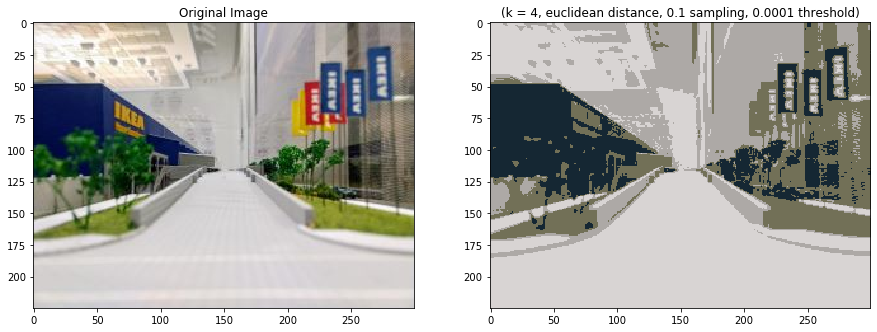

In [19]:
# to change test picture
file_loc = "data/sample.jpg"

# parameters used in KMedoids
#list_num_clusters = [2,8,32]
num_clusters = 4

#list_metrics = ["cityblock", "euclidean", "mahalanobis"]
metric = "euclidean"

#samplings = [0.1, 0.2, 0.3]
sampling = 0.1

#thresholds = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
threshold = 1e-4

max_iterations = 100
runs = 1

costs = []
iterations = []

for run in range(runs):
    # start with KMedoids
    start_time = timeit.default_timer() 
    kmedoids_alg = KMedoids(file_loc, clusters = num_clusters, metric = metric, sampling = sampling, threshold = threshold, max_iterations = max_iterations)

    kmedoids_alg.search()
    end_time = timeit.default_timer()
    print("KMedoids Run Time: %.2f seconds." % (end_time - start_time))

    costs.append(kmedoids_alg.costs)
    iterations.append(kmedoids_alg.total_iterations)

    # compare images
    new_img = kmedoids_alg.write_img(kmedoids_alg.clusters, kmedoids_alg.centers)
    compare_img(file_loc, new_img, num_clusters, metric, sampling, threshold)

    # save output
    output_class_file = "../Outputs/KMedoids_Classes.txt"
    output_centroids_file = "../Outputs/KMedoids_Centroids.txt"

    np.savetxt(output_class_file, kmedoids_alg.clusters, fmt="%d")
    np.savetxt(output_centroids_file, kmedoids_alg.centers, fmt="%d")

## Plot Convergence

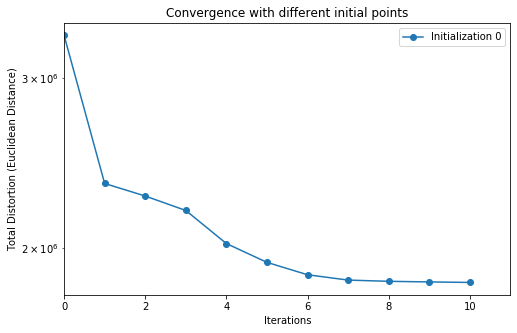

In [20]:
# plot convergence
plt.figure(figsize = (8, 5))
max_iter = 0
max_dist = 0
min_dist = 0

for i in range(runs):
    #plt.plot(iterations[i], costs[i], 'o-', markersize = 6, label = "k = %d" % list_num_clusters[i])
    #plt.plot(iterations[i], costs[i], 'o-', markersize = 6, label = "Sampling Percentage %.1f" % samplings[i])
    plt.plot(iterations[i], costs[i], 'o-', markersize = 6, label = "Initialization %d" % i)
    max_iter = max(max(iterations[i]), max_iter)
    max_dist = max(max(costs[i]), max_dist)
    min_dist = min(min(costs[i]), min_dist)

plt.title("Convergence with different initial points")
plt.yticks(ticks=range((int)(min_dist), (int)(max_dist), (int)((max_dist - min_dist) / 10)))
plt.yscale("log")
plt.ylabel("Total Distortion (Euclidean Distance)")
plt.xlabel("Iterations")
plt.xlim([0, max_iter])
plt.legend()
plt.show()